# UCI Machine Learning Datasets: Animals (Multi-label Categorical)

This notebook utilizes modern machine learning techniques to create solutions for the elementary animal zoo dataset.

UC Irvine's Machine Learning department houses many datasets. These datasets are designed to be extremely reliable and allow algorithms to create excellent solutions. The UCI ML animal dataset provides quantifiable features and multiple categories to classify an animal. The animals are given their proper name as well, but for the scope of this notebook they are disregarded.

This problem is a **multi-label categorical classification problem**, one of the most common classification problems in machine learning. The key to categorical classification is creating or finding datasets that fully represent all available categories in a balanced fashion. For example, the UCI ML animals dataset is relatively balanced and has datapoints for all seven categories. If the dataset contained thousands of animals, the result would only become more precise. However, this comes with the limitation of having to rebuild our model from scratch when a new multi-label category is introduced. 

Multi-label classification also relies on **softmax** activation in the output layer to finalize. [Softmax activation](https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d) is an algorithm that assigns normalized probabilities for each label. The algorithm does this by looking at the output vector of a model (length = # of labels). Softmax activation is only mentioned to give context to the TensorFlow model featured in this notebook.

In [235]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [236]:
# A method that plots a confusion matrix nicely
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
    cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize: plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
      else: plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [237]:
# Function to encode the classifier
def enc_class(c):
  return np.array([1 if c==i else 0 for i in range(num_classes)], dtype='float64')

### Data Preparation

In [238]:
# Load the raw data
df = pd.read_csv('zoo.csv')

In [239]:
print('Zoo DataFrame')
print(df.shape)
df.head()

Zoo DataFrame
(101, 18)


,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [240]:
# Check for null values
df.isnull().sum()

animal_name    0
hair           0
feathers       0
eggs           0
milk           0
airborne       0
aquatic        0
predator       0
toothed        0
backbone       0
breathes       0
venomous       0
fins           0
legs           0
tail           0
domestic       0
catsize        0
class_type     0
dtype: int64

In [241]:
# Get unique class names
num_classes = len(df['class_type'].unique())
df['class_type'].unique()

array([1, 4, 2, 7, 6, 5, 3])

In [242]:
# Check for dataset balance
df['class_type'].value_counts().sort_index()

1    41
2    20
3     5
4    13
5     4
6     8
7    10
Name: class_type, dtype: int64

In [243]:
# Create the encoder
enc = OneHotEncoder()
enc

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [244]:
# Remove the animal name column as it's not a feature
df = df.drop(['animal_name'], axis=1)
df.head()

,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [245]:
# Encode the dataset
df_enc = enc.fit_transform(df).toarray()
df_enc

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [246]:
# Calculate feature names for presentation
enc_names = enc.get_feature_names(df.columns)
enc_names

array(['hair_0', 'hair_1', 'feathers_0', 'feathers_1', 'eggs_0', 'eggs_1',
       'milk_0', 'milk_1', 'airborne_0', 'airborne_1', 'aquatic_0',
       'aquatic_1', 'predator_0', 'predator_1', 'toothed_0', 'toothed_1',
       'backbone_0', 'backbone_1', 'breathes_0', 'breathes_1',
       'venomous_0', 'venomous_1', 'fins_0', 'fins_1', 'legs_0', 'legs_2',
       'legs_4', 'legs_5', 'legs_6', 'legs_8', 'tail_0', 'tail_1',
       'domestic_0', 'domestic_1', 'catsize_0', 'catsize_1',
       'class_type_1', 'class_type_2', 'class_type_3', 'class_type_4',
       'class_type_5', 'class_type_6', 'class_type_7'], dtype=object)

In [247]:
'Number of Encoded Features (Including Classification): {}'.format(len(enc_names))

'Number of Encoded Features (Including Classification): 43'

In [248]:
'Number of Encoded Features (Excluding Classification): {}'.format(len(enc_names) - num_classes)

'Number of Encoded Features (Excluding Classification): 36'

In [249]:
# Split the encoded dataset into train and test groups
train, test = train_test_split(df_enc)

In [250]:
# Get size of the datasets
print('Train Size: {}'.format(len(train)))
print('Test Size: {}'.format(len(test)))

Train Size: 75
Test Size: 26


In [251]:
# Split the datasets into x and y
train_x = train[:,:-num_classes]
train_y = train[:,-num_classes:]
test_x = test[:,:-num_classes]
test_y = test[:,-num_classes:]

In [252]:
# Use argmax to find labels. Useful for comparing predictions!
train_y_max = np.argmax(train_y, axis=1)
test_y_max = np.argmax(test_y, axis=1) 

In [253]:
print(train_x[:10])
print(train_y[:10])
print(test_x[:10])
print(test_y[:10])

[[1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
  0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1.
  1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.]
 [0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0.
  0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1.]
 [1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0.
  0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.]
 [1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1.
  1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0.]
 [1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0.
  0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0.
  0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0.
  0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1.
  1. 0. 0. 0. 0. 0. 0.

### Model: TensorFlow 3-Layer Sequential Neural Network

Because the features in the dataset are easily encodable (some even come coded) and contains no null values, this problem is perfect for a neural network. The only problem would be **dataset bias**, or the event where the neural network performs great on the dataset it was fit to but performs poorly on extensions of the dataset.

In [254]:
from keras.models import Sequential
from keras.layers import Input, Activation, Dense

In [255]:
# Create the neural network
nn = Sequential()

In [256]:
# Add layers to the model
nn.add(Input(train_x.shape[1]))
nn.add(Dense(8))
nn.add(Activation('sigmoid'))
nn.add(Dense(num_classes))
nn.add(Activation('softmax')) # 'softmax' activation for multi-class categorical classification

In [257]:
# Compile the neural network
nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [258]:
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 296       
_________________________________________________________________
activation_2 (Activation)    (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 63        
_________________________________________________________________
activation_3 (Activation)    (None, 7)                 0         
Total params: 359
Trainable params: 359
Non-trainable params: 0
_________________________________________________________________


In [259]:
nn_history = nn.fit(train_x, train_y, batch_size=10, epochs=100, verbose=2, validation_data=(test_x, test_y))

Epoch 1/100
8/8 - 1s - loss: 2.0931 - accuracy: 0.0667 - val_loss: 2.0585 - val_accuracy: 0.0000e+00
Epoch 2/100
8/8 - 0s - loss: 2.0422 - accuracy: 0.0667 - val_loss: 2.0104 - val_accuracy: 0.0000e+00
Epoch 3/100
8/8 - 0s - loss: 1.9941 - accuracy: 0.0667 - val_loss: 1.9663 - val_accuracy: 0.0000e+00
Epoch 4/100
8/8 - 0s - loss: 1.9495 - accuracy: 0.0667 - val_loss: 1.9235 - val_accuracy: 0.0000e+00
Epoch 5/100
8/8 - 0s - loss: 1.9107 - accuracy: 0.0667 - val_loss: 1.8827 - val_accuracy: 0.0000e+00
Epoch 6/100
8/8 - 0s - loss: 1.8717 - accuracy: 0.1600 - val_loss: 1.8449 - val_accuracy: 0.1154
Epoch 7/100
8/8 - 0s - loss: 1.8358 - accuracy: 0.3067 - val_loss: 1.8096 - val_accuracy: 0.3462
Epoch 8/100
8/8 - 0s - loss: 1.8023 - accuracy: 0.3733 - val_loss: 1.7769 - val_accuracy: 0.4615
Epoch 9/100
8/8 - 0s - loss: 1.7709 - accuracy: 0.3867 - val_loss: 1.7468 - val_accuracy: 0.4615
Epoch 10/100
8/8 - 0s - loss: 1.7431 - accuracy: 0.3867 - val_loss: 1.7179 - val_accuracy: 0.4615
Epoch 11/

In [260]:
# Create predictions using the neural network
nn_pred = nn.predict(test_x, batch_size=128) # This will keep probabilities for each classification
nn_pred_max = np.argmax(nn_pred, axis=1)

In [261]:
# Calculate the confusion matrix of real vs. NN predictions
cm = tf.math.confusion_matrix(test_y_max, nn_pred_max, num_classes=num_classes)
cm

<tf.Tensor: shape=(7, 7), dtype=int32, numpy=
array([[12,  0,  0,  0,  0,  0,  0],
       [ 0,  5,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  0,  0],
       [ 2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  1,  2]], dtype=int32)>

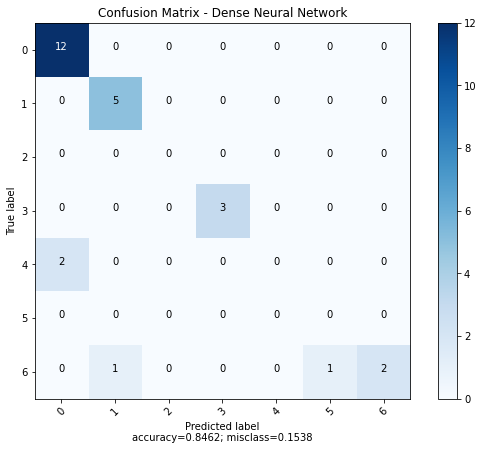

In [262]:
plot_confusion_matrix(cm=cm.numpy(), target_names=range(num_classes), normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix - Dense Neural Network')

### Model: Random Forest Classification

Random Forest Classification is a specialized algorithm designed to tackle multi-label classification problems by creating a vast "forest" of `n` decision trees. A decision tree is a flowchart-esque model where an input starts at the root of the tree, processes the current node's decision using the input, and the progress to the specific child node depending on the decision's result until a predicted classification is given.

![](https://i.imgur.com/DYxQmRb.png)

This notebook creates a variety of random forests each with a different number of trees (n=1,10,25,...). A confusion matrix will be generated to determine the performance of the random forest algorithm for each given `n`.

In [263]:
from sklearn.ensemble import RandomForestClassifier

In [264]:
# Create forests with a variety of trees
n = [1,10,25,50,100] # The different random forests and their respective n
forests = {}
for i in n:
  forests[i] = RandomForestClassifier(n_estimators=i, random_state=0)
  forests[i].fit(train_x, train_y)

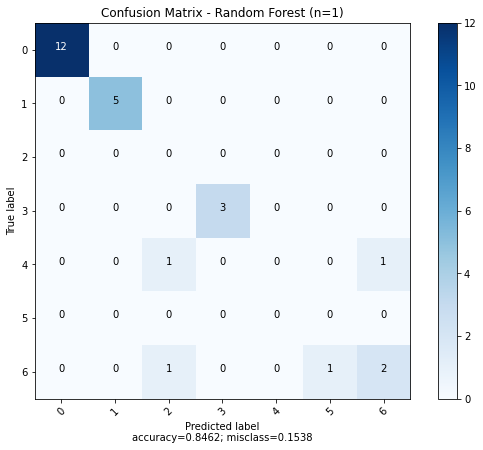

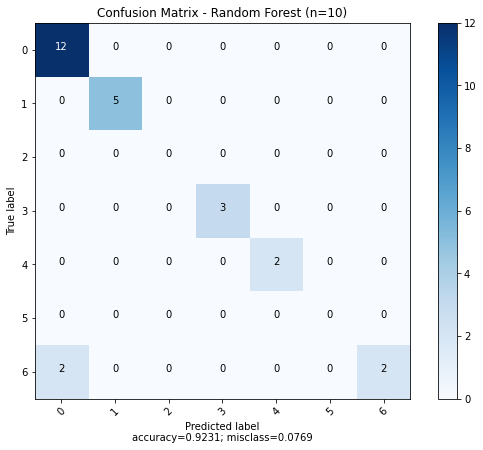

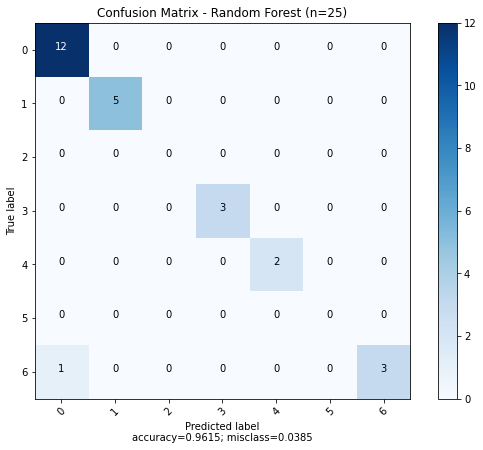

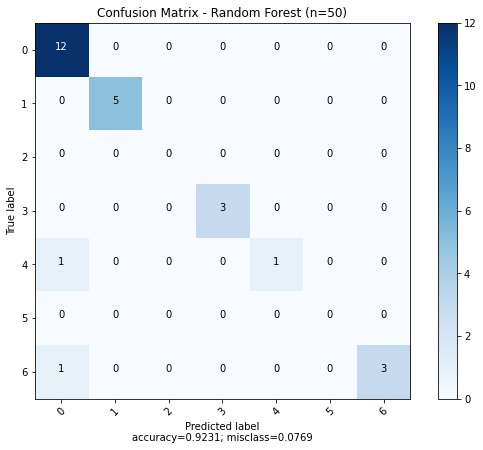

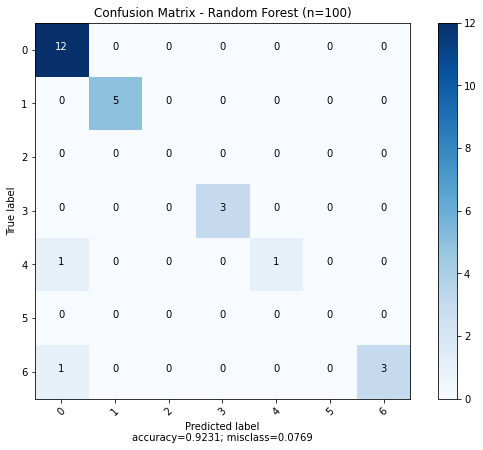

In [265]:
# Iterate over all forests
for i in n:
  # Create the prediction using the random forest 
  forests_pred = np.argmax(forests[i].predict(test_x), axis=1)

  # Plot the confusion matrix for the random forest
  cm = tf.math.confusion_matrix(test_y_max, forests_pred, num_classes=num_classes)
  plot_confusion_matrix(cm=cm.numpy(), target_names=range(num_classes), normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix - Random Forest (n={})'.format(i))

plt.show()

Compared to the MNIST digit problem, this dataset performs better for this problem. Perhaps image analysis problems, or rather large input vectors, do not perform well on random forest classifiers. It would require more experience and possibly a case study into the **performance of random forest classifiers** as the **dimension of the input vector increases**.

### Model: XGBoost

Similar to Random Forest Classification, [XGBoost](https://xgboost.readthedocs.io/en/latest/) employs an array of decision trees in an attempt to classify inputs. However, XGBoost goes a step further an incorporates complex algorithms, such as graident boosting and regularization, to increase the performance of the model. XGBoost is the more modern approach to this type of classification algorithm and, in theory, will provide better results than that of the Random Forest Classification algorithm.

![](https://i.imgur.com/dO3F1BS.png)

In [266]:
import xgboost as xgb

In [267]:
# Create XGBoost matrices for training and testing data
xgb_train = xgb.DMatrix(train_x, label=train_y_max)
xgb_test = xgb.DMatrix(test_x, label=test_y_max)

In [268]:
# Create param dictionary
param = {
    'max_depth': 5,
    'eta': 0.3,
    'silent': 0,
    'objective': 'multi:softmax',
    'num_class': num_classes
}
xgb_epochs = 500

# Train the model
xgb_model = xgb.train(param, xgb_train, xgb_epochs)

In [269]:
# Create the XGBoost predictions
xgb_pred = xgb_model.predict(xgb_test)

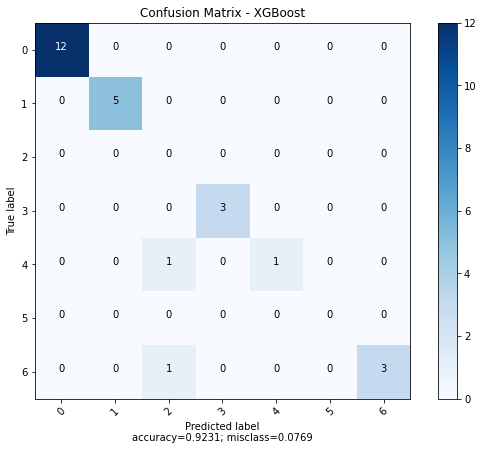

In [270]:
# Plot the XGBoost confusion matrix
cm = tf.math.confusion_matrix(test_y_max, xgb_pred, num_classes=num_classes)
plot_confusion_matrix(cm=cm.numpy(), target_names=range(num_classes), normalize=False, cmap=plt.cm.Blues, title='Confusion Matrix - XGBoost')
plt.show()

### Final Thoughts

XGBoost seems like the go-to algorithm for modern machine learning. It's extremely adaptive, performs well on a variety of problems, but may have long training times on larger datasets. 

For the scope of this notebook (and possibly similar level problems), XGBoost is an ideal algorithm for the most hands off machine learning approach. However, the possibilities of the TensorFlow library are seemingly endless. The models a developer can create using the library will out perform XGBoost in the long run. However, TensorFlow is a very extensive and complex library. Not only does the developer have to understand machine learning concepts, the developer must have a grasp on the underlying mathematics involving tensors and multi-dimensional problems.